## Import Library

In [1]:
import numpy as np
import os
from google.colab import files
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2

## Load Data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilahsofieyanti","key":"58045bfbf7b7656f85c1aa4f83a7a40d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d sanknn/facemask-detection

100% 499M/501M [00:19<00:00, 28.7MB/s]
100% 501M/501M [00:19<00:00, 27.1MB/s]


In [5]:
!unzip facemask-detection.zip -d facemask-dataset

Streaming output truncated to the last 5000 lines.
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_1344_1873401.png  
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_1345_1716050.png  
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_1346_9262995.png  
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_1347_2351946.png  
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_1348_5252517.png  
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_1349_7973583.png  
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_134_2881434.png  
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_1350_6253966.png  
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_1351_5182308.png  
  inflating: facemask-dataset/Facemaskdetection/train/Without_mask/augmented_1352_3803

## Data Preprocessing

In [9]:
train_dir = "/content/facemask-dataset/Facemaskdetection/train"
val_dir = "/content/facemask-dataset/Facemaskdetection/val"

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)


validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0)

In [11]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))



Found 8118 images belonging to 2 classes.
Found 1822 images belonging to 2 classes.


## Training and compile

In [12]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(224, 224, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
x = AveragePooling2D(pool_size=(7, 7))(last_output)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)

model = Model(pre_trained_model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
lr=0.0001
epochs=20

optimizer = tf.optimizers.Adam(lr=lr, decay=lr/epochs )
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
history = model.fit(train_generator, 
                    steps_per_epoch=20,
                    epochs = 20, 
                    validation_steps = 5,
                    validation_data=validation_generator
                    )

Epoch 1/20
20/20 [==============================] - 37s 2s/step - loss: 0.5949 - accuracy: 0.7406 - val_loss: 0.4164 - val_accuracy: 0.9500
Epoch 2/20
20/20 [==============================] - 33s 2s/step - loss: 0.3748 - accuracy: 0.9190 - val_loss: 0.2895 - val_accuracy: 0.9625
Epoch 3/20
20/20 [==============================] - 33s 2s/step - loss: 0.2658 - accuracy: 0.9406 - val_loss: 0.1853 - val_accuracy: 0.9937
Epoch 4/20
20/20 [==============================] - 34s 2s/step - loss: 0.2206 - accuracy: 0.9438 - val_loss: 0.1526 - val_accuracy: 0.9688
Epoch 5/20
20/20 [==============================] - 33s 2s/step - loss: 0.1634 - accuracy: 0.9641 - val_loss: 0.1300 - val_accuracy: 0.9750
Epoch 6/20
20/20 [==============================] - 34s 2s/step - loss: 0.1336 - accuracy: 0.9794 - val_loss: 0.1038 - val_accuracy: 0.9812
Epoch 7/20
20/20 [==============================] - 33s 2s/step - loss: 0.1404 - accuracy: 0.9531 - val_loss: 0.0909 - val_accuracy: 0.9812
Epoch 8/20
20/20 [==

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 33s 2s/step - loss: 0.1031 - accuracy: 0.9734 - val_loss: 0.0915 - val_accuracy: 0.9750
Epoch 11/20
20/20 [==============================] - 32s 2s/step - loss: 0.1017 - accuracy: 0.9746 - val_loss: 0.0645 - val_accuracy: 0.9937
Epoch 12/20
20/20 [==============================] - 34s 2s/step - loss: 0.0917 - accuracy: 0.9703 - val_loss: 0.0571 - val_accuracy: 0.9875
Epoch 13/20
20/20 [==============================] - 32s 2s/step - loss: 0.0880 - accuracy: 0.9781 - val_loss: 0.0741 - val_accuracy: 0.9750
Epoch 14/20
20/20 [==============================] - 33s 2s/step - loss: 0.0891 - accuracy: 0.9719 - val_loss: 0.0777 - val_accuracy: 0.9937
Epoch 15/20
20/20 [==============================] - 33s 2s/step - loss: 0.0798 - accuracy: 0.9781 - val_loss: 0.0686 - val_accuracy: 0.9812
Epoch 16/20
20/20 [==============================] - 32s 2s/step - loss: 0.0978 - accuracy: 0.9703 - val_loss: 0.0625 - val_accuracy: 0.9812
Epoch 17/20
20/20 [======

## Plot Loss and Accuracy

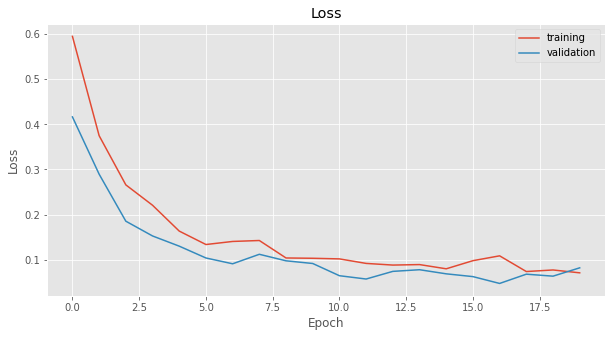

In [16]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, epochs), history.history["loss"], label="training")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


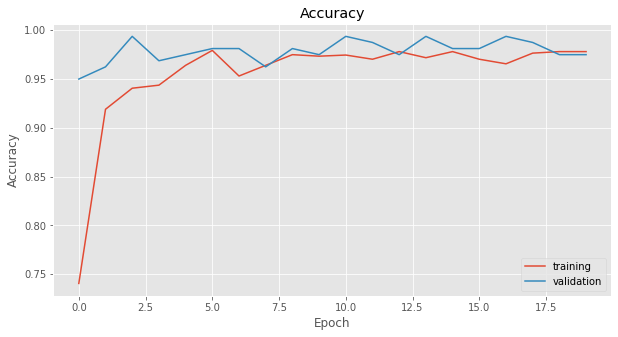

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## Test

In [18]:
print(train_generator.class_indices)

{'With_mask': 0, 'Without_mask': 1}


Saving 00000.png to 00000.png
1/1 [==============================] - 0s 63ms/step
00000.png
without_mask


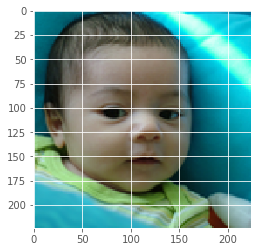

In [21]:
from tensorflow.keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
 
  path = fn
  img = image.load_img(path, target_size=(224,224))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  output_class = np.argmax(classes)
  print(fn)
  if output_class==0:
    print('with_mask')
  else:
    print('without_mask')

Saving test.jpg to test.jpg
1/1 [==============================] - 0s 59ms/step
test.jpg
with_mask


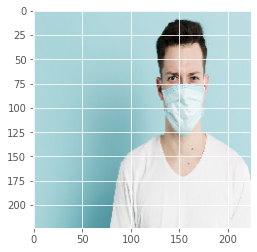

In [22]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  path = fn
  img = image.load_img(path, target_size=(224,224))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  output_class = np.argmax(classes)
  print(fn)
  if output_class==0:
    print('with_mask')
  else:
    print('without_mask')

## Save Model

In [23]:
model.save('model-facemask.h5')